# NNet class in Pytorch

Versions:

* 3.3: *Added calls to `np.random.seed(42)` to force the shuffle in our partition function to result in the same random arrangement of samples each time, to help with your debugging.*
* 3.2: *RMSE in example output of `generate_k_fold_cross_validation_sets` are corrected. `A3grader.zip` updated.*
* 3.1: *`A3grader.zip` is now available.  The `generate_k_fold_cross_validation_sets` function had an error that is fixed in this version.*

* 3.0: *`A3grader.zip` is not available yet.*

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [2]:
import numpy as np
import torch 
import pandas
import matplotlib.pyplot as plt
import pdb
from itertools import product 


Complete the following definition of class `NNet` by completing its `train` function.

In [3]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh', gpu = False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        self.gpu = gpu
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
        
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
        if self.gpu:
            self.Xmeans = self.Xmeans.to('cuda')
            self.Xstds = self.Xstds.to('cuda')
            self.Tmeans = self.Tmeans.to('cuda')
            self.Tstds = self.Tstds.to('cuda')
            X = X.to('cuda')
            T = T.to('cuda')        

        

        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
       

#         model = torch.nn.Sequential(self.hidden_layers)


        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        epochs_per_print = n_epochs // 10
        for epoch in range(n_epochs):
            Y = self.forward(X)        
    
            mse = mse_func(T, Y)
            mse.backward()
            #pdb.set_trace()
            error_convert_f = lambda err: (torch.sqrt(err) * self.Tstds)[0] # to scalar
            error = error_convert_f(mse)
            self.error_trace.append(error)
#             error_trace =error_trace.detach().numpy()
            optimizer.step() 
            optimizer.zero_grad()
            
            if self.gpu:
                if (epoch + 1) % max(1, epochs_per_print) == 0:
                    print(f'Epoch {epoch+1:d} Error|={error.cpu().detach().numpy():.5f}')
            else:
                if (epoch + 1) % max(1, epochs_per_print) == 0:
                    print(f'Epoch {epoch+1:d} Error|={error.detach().numpy():.5f}')

    def use(self, X):
        
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
            if self.gpu:
                X = torch.tensor(X).to('cuda')
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y_un = self.forward(X)
        Y = (Y_un*self.Tstds) + self.Tmeans
#         print(Y)
        
        # Return output Y after detaching from computation graph and converting to numpy
        if self.gpu:
            return Y.cpu().detach().numpy()
        else:
            return Y.detach().numpy()

## Example

In [8]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')


Epoch 5 Error|=11.15545
Epoch 10 Error|=6.06195
Epoch 15 Error|=5.16921
Epoch 20 Error|=2.10268
Epoch 25 Error|=2.31699
Epoch 30 Error|=2.63575
Epoch 35 Error|=1.46300
Epoch 40 Error|=1.13660
Epoch 45 Error|=1.17029
Epoch 50 Error|=0.92157
RMSE 0.867


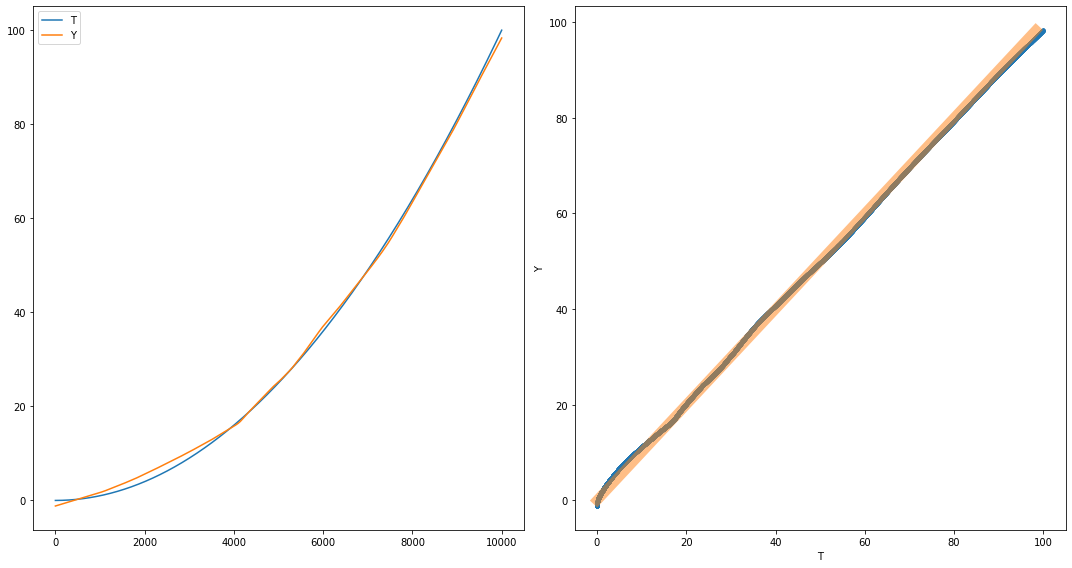

In [29]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [4]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [17]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]), array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [18]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [5]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func,gpu=False):
    results=[]
    
    for hidden_units in list_of_n_hiddens:
    #                     net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
    #                     net.train(X, T, 50, 0.01)
        rmse_train = 0
        rmse_val = 0
        rmse_test = 0
        for  Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            if gpu:
                nnet = NNet(Xtrain.shape[1], hidden_units,Ttrain.shape[1],act_func=act_func, gpu=True)
                nnet.cuda()
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)
                

            else:
                nnet = NNet(Xtrain.shape[1], hidden_units,Ttrain.shape[1],act_func=act_func)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)

            rmse_train += rmse(Ttrain, nnet.use(Xtrain))
            rmse_val += rmse(Tvalidate, nnet.use(Xvalidate))
            rmse_test += rmse(Ttest, nnet.use(Xtest))




        results.append([ hidden_units,
                                rmse_train/n_folds,
                               rmse_val/n_folds,
                                rmse_test/n_folds])
    df = pandas.DataFrame(results, columns=('Arch','train RMSE',
                                                'validate RMSE', 'RMSE Test'))
    #         print(df)  
    return df

    
    
    
#     for (list_of_n_hiddens,n_epochs,learning_rate,act_func) in product(list_of_n_hiddens,n_epochs,learning_rate,act_func):
#         print(list_of_n_hiddens,n_epochs,learning_rate,act_func)

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [0]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

T =airfoil.iloc[:,5:6].values
X =airfoil.iloc[:,0:5].values


Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described with at least 10 sentences.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [0]:
result=[]

In [13]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5],[50,50],[100,100],[200,300], [200,300,100],[200,300,100,50]],
                                      400, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours on CPU')
result.append(results)

Epoch 40 Error|=3.91575
Epoch 80 Error|=3.48790
Epoch 120 Error|=3.48408
Epoch 160 Error|=3.48398
Epoch 200 Error|=3.48398
Epoch 240 Error|=3.48398
Epoch 280 Error|=3.48398
Epoch 320 Error|=3.48398
Epoch 360 Error|=3.48398
Epoch 400 Error|=3.48398
Epoch 40 Error|=3.55350
Epoch 80 Error|=2.88347
Epoch 120 Error|=2.87423
Epoch 160 Error|=2.87420
Epoch 200 Error|=2.87420
Epoch 240 Error|=2.87420
Epoch 280 Error|=2.87420
Epoch 320 Error|=2.87420
Epoch 360 Error|=2.87420
Epoch 400 Error|=2.87420
Epoch 40 Error|=3.35570
Epoch 80 Error|=3.34898
Epoch 120 Error|=3.34869
Epoch 160 Error|=3.34869
Epoch 200 Error|=3.34869
Epoch 240 Error|=3.34869
Epoch 280 Error|=3.34869
Epoch 320 Error|=3.34869
Epoch 360 Error|=3.34869
Epoch 400 Error|=3.34869
Epoch 40 Error|=3.28405
Epoch 80 Error|=3.28006
Epoch 120 Error|=3.28003
Epoch 160 Error|=3.28003
Epoch 200 Error|=3.28003
Epoch 240 Error|=3.28003
Epoch 280 Error|=3.28003
Epoch 320 Error|=3.28003
Epoch 360 Error|=3.28003
Epoch 400 Error|=3.28003
Epoch 40

Epoch 200 Error|=2.93774
Epoch 240 Error|=2.75790
Epoch 280 Error|=2.61804
Epoch 320 Error|=2.50658
Epoch 360 Error|=2.41551
Epoch 400 Error|=2.33939
Epoch 40 Error|=5.34836
Epoch 80 Error|=3.60691
Epoch 120 Error|=3.10323
Epoch 160 Error|=2.78427
Epoch 200 Error|=2.56655
Epoch 240 Error|=2.40742
Epoch 280 Error|=2.28581
Epoch 320 Error|=2.18997
Epoch 360 Error|=2.11242
Epoch 400 Error|=2.04816
Epoch 40 Error|=4.07554
Epoch 80 Error|=2.93059
Epoch 120 Error|=2.54154
Epoch 160 Error|=2.33811
Epoch 200 Error|=2.20881
Epoch 240 Error|=2.11196
Epoch 280 Error|=2.03365
Epoch 320 Error|=1.96875
Epoch 360 Error|=1.91428
Epoch 400 Error|=1.86797
Epoch 40 Error|=5.80539
Epoch 80 Error|=4.14229
Epoch 120 Error|=3.36961
Epoch 160 Error|=2.87322
Epoch 200 Error|=2.57531
Epoch 240 Error|=2.38310
Epoch 280 Error|=2.24752
Epoch 320 Error|=2.14482
Epoch 360 Error|=2.06318
Epoch 400 Error|=1.99616
Epoch 40 Error|=5.08231
Epoch 80 Error|=3.46433
Epoch 120 Error|=2.88964
Epoch 160 Error|=2.62010
Epoch 20

Epoch 280 Error|=0.29677
Epoch 320 Error|=0.26163
Epoch 360 Error|=0.23986
Epoch 400 Error|=0.21818
Epoch 40 Error|=1.50618
Epoch 80 Error|=0.70379
Epoch 120 Error|=0.44312
Epoch 160 Error|=0.34629
Epoch 200 Error|=0.28893
Epoch 240 Error|=0.25119
Epoch 280 Error|=0.22336
Epoch 320 Error|=0.20071
Epoch 360 Error|=0.18131
Epoch 400 Error|=0.16444
Epoch 40 Error|=2.24757
Epoch 80 Error|=0.85549
Epoch 120 Error|=0.59609
Epoch 160 Error|=0.45720
Epoch 200 Error|=0.36416
Epoch 240 Error|=0.30180
Epoch 280 Error|=0.25892
Epoch 320 Error|=0.22842
Epoch 360 Error|=0.20597
Epoch 400 Error|=0.18862
Epoch 40 Error|=2.06182
Epoch 80 Error|=0.89351
Epoch 120 Error|=0.61220
Epoch 160 Error|=0.47622
Epoch 200 Error|=0.38628
Epoch 240 Error|=0.32093
Epoch 280 Error|=0.27120
Epoch 320 Error|=0.23252
Epoch 360 Error|=0.20197
Epoch 400 Error|=0.17744
Epoch 40 Error|=1.75452
Epoch 80 Error|=0.76150
Epoch 120 Error|=0.51890
Epoch 160 Error|=0.39025
Epoch 200 Error|=0.31374
Epoch 240 Error|=0.26154
Epoch 28

Epoch 360 Error|=0.14680
Epoch 400 Error|=0.13238
Epoch 40 Error|=1.58669
Epoch 80 Error|=0.78076
Epoch 120 Error|=0.59305
Epoch 160 Error|=0.51460
Epoch 200 Error|=0.45516
Epoch 240 Error|=0.40531
Epoch 280 Error|=0.36273
Epoch 320 Error|=0.32596
Epoch 360 Error|=0.29392
Epoch 400 Error|=0.26593
Epoch 40 Error|=2.68860
Epoch 80 Error|=0.87808
Epoch 120 Error|=0.57549
Epoch 160 Error|=0.46361
Epoch 200 Error|=0.39457
Epoch 240 Error|=0.34675
Epoch 280 Error|=0.31127
Epoch 320 Error|=0.28357
Epoch 360 Error|=0.26108
Epoch 400 Error|=0.24227
Epoch 40 Error|=2.28798
Epoch 80 Error|=0.94689
Epoch 120 Error|=0.66900
Epoch 160 Error|=0.54345
Epoch 200 Error|=0.45002
Epoch 240 Error|=0.37793
Epoch 280 Error|=0.32268
Epoch 320 Error|=0.28038
Epoch 360 Error|=0.24729
Epoch 400 Error|=0.22067
Epoch 40 Error|=1.84029
Epoch 80 Error|=0.87254
Epoch 120 Error|=0.60519
Epoch 160 Error|=0.50658
Epoch 200 Error|=0.44323
Epoch 240 Error|=0.39521
Epoch 280 Error|=0.35643
Epoch 320 Error|=0.32381
Epoch 36

Epoch 400 Error|=0.03480
Epoch 40 Error|=2.55490
Epoch 80 Error|=0.74168
Epoch 120 Error|=0.43182
Epoch 160 Error|=0.26556
Epoch 200 Error|=0.19033
Epoch 240 Error|=0.14463
Epoch 280 Error|=0.14357
Epoch 320 Error|=0.15453
Epoch 360 Error|=0.08799
Epoch 400 Error|=0.07541
Epoch 40 Error|=1.94521
Epoch 80 Error|=0.58819
Epoch 120 Error|=0.29127
Epoch 160 Error|=0.19303
Epoch 200 Error|=0.14745
Epoch 240 Error|=0.11921
Epoch 280 Error|=0.09892
Epoch 320 Error|=0.16708
Epoch 360 Error|=0.08482
Epoch 400 Error|=0.17584
Epoch 40 Error|=1.95904
Epoch 80 Error|=0.65379
Epoch 120 Error|=0.34285
Epoch 160 Error|=0.23405
Epoch 200 Error|=0.17435
Epoch 240 Error|=0.14983
Epoch 280 Error|=0.11648
Epoch 320 Error|=0.49875
Epoch 360 Error|=0.10221
Epoch 400 Error|=0.34192
Epoch 40 Error|=1.32089
Epoch 80 Error|=0.35056
Epoch 120 Error|=0.23941
Epoch 160 Error|=0.19262
Epoch 200 Error|=0.16109
Epoch 240 Error|=0.13637
Epoch 280 Error|=0.11538
Epoch 320 Error|=0.09754
Epoch 360 Error|=0.08308
Epoch 40

NameError: name 'result' is not defined

Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [6]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]
    plt.figure(figsize=(15, 15))

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    

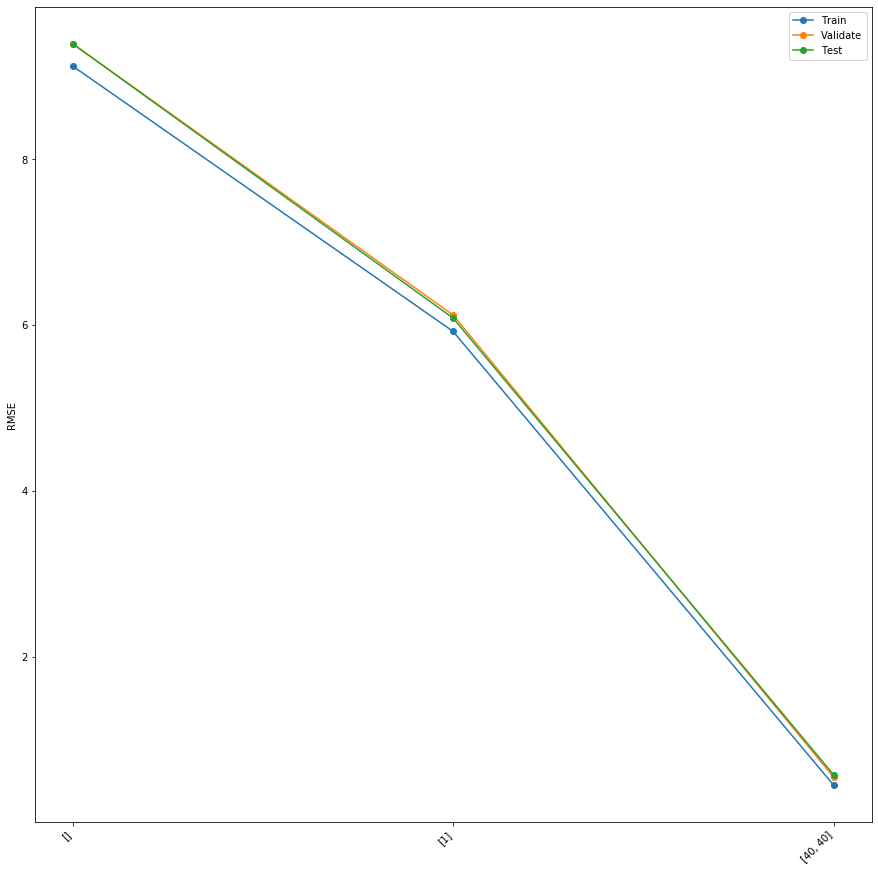

In [11]:
plot_results(results)

In [12]:
results

,Arch,train RMSE,validate RMSE,RMSE Test
0,[],9.121618,9.390552,9.390552
1,[1],5.921503,6.118484,6.081694
2,"[40, 40]",0.450758,0.546066,0.575584


# Observations

1) We can see that the test and validation error reduces with increase in layers of the Nueral Network.

2) With increasing number of elements in each layer we could also observe a decrease in the test and validation error.

3) For the larger layers with lower epoch(200 default case) the error value was decreasing, Increasing the number of epochs had a better test and validation results for larger models. 

4) 


# Grading and Check-In

Your notebook will be partially run and graded automatically. Test this grading process by first downloading [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A3grader.zip) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 90/90 if your functions are defined correctly. The remaining 10 points will be based on other testing and the results you obtain and your discussions.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.

For the grading script to run correctly, you must first name this notebook as `Lastname-A3.ipynb`| with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

In [1]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gannavarapu_A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]

Epoch 10 Error|=0.87483
Epoch 20 Error|=0.69854
Epoch 30 Error|=0.42182
Epoch 40 Error|=0.36691
Epoch 50 Error|=0.27834
Epoch 60 Error|=0.23354
Epoch 70 Error|=0.21923
Epoch 80 Error|=0.20792
Epoch 90 Error|=0.19651
Epoch 100 Error|=0.18570

--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, v

In [9]:
torch.manual_seed(400)
np.random.seed(400)

X = np.arange(600).reshape(200, 3)
T = np.log(1 + X[:, 0:1]) ** 2

results = run_k_fold_cross_validation(X, T, 4,
                                      [[], [1], [40, 40]],
                                      500, 0.01, 'tanh')

Epoch 50 Error|=3.68361
Epoch 100 Error|=3.63788
Epoch 150 Error|=3.63765
Epoch 200 Error|=3.63765
Epoch 250 Error|=3.63765
Epoch 300 Error|=3.63765
Epoch 350 Error|=3.63765
Epoch 400 Error|=3.63765
Epoch 450 Error|=3.63765
Epoch 500 Error|=3.63765
Epoch 50 Error|=3.02642
Epoch 100 Error|=3.02088
Epoch 150 Error|=3.02088
Epoch 200 Error|=3.02088
Epoch 250 Error|=3.02088
Epoch 300 Error|=3.02088
Epoch 350 Error|=3.02088
Epoch 400 Error|=3.02088
Epoch 450 Error|=3.02088
Epoch 500 Error|=3.02088
Epoch 50 Error|=3.28443
Epoch 100 Error|=3.28289
Epoch 150 Error|=3.28266
Epoch 200 Error|=3.28266
Epoch 250 Error|=3.28266
Epoch 300 Error|=3.28266
Epoch 350 Error|=3.28266
Epoch 400 Error|=3.28266
Epoch 450 Error|=3.28266
Epoch 500 Error|=3.28266
Epoch 50 Error|=3.63872
Epoch 100 Error|=3.63767
Epoch 150 Error|=3.63765
Epoch 200 Error|=3.63765
Epoch 250 Error|=3.63765
Epoch 300 Error|=3.63765
Epoch 350 Error|=3.63765
Epoch 400 Error|=3.63765
Epoch 450 Error|=3.63765
Epoch 500 Error|=3.63765
Epoc

Epoch 50 Error|=1.70153
Epoch 100 Error|=0.83283
Epoch 150 Error|=0.61478
Epoch 200 Error|=0.47891
Epoch 250 Error|=0.38249
Epoch 300 Error|=0.31215
Epoch 350 Error|=0.25842
Epoch 400 Error|=0.21694
Epoch 450 Error|=0.18534
Epoch 500 Error|=0.16775
Epoch 50 Error|=1.42204
Epoch 100 Error|=0.71814
Epoch 150 Error|=0.49611
Epoch 200 Error|=0.39526
Epoch 250 Error|=0.33296
Epoch 300 Error|=0.28378
Epoch 350 Error|=0.24319
Epoch 400 Error|=0.20975
Epoch 450 Error|=0.20184
Epoch 500 Error|=0.16241
Epoch 50 Error|=1.40205
Epoch 100 Error|=0.68568
Epoch 150 Error|=0.47021
Epoch 200 Error|=0.33091
Epoch 250 Error|=0.38625
Epoch 300 Error|=0.21450
Epoch 350 Error|=0.17612
Epoch 400 Error|=0.15076
Epoch 450 Error|=0.13127
Epoch 500 Error|=0.17127


In [10]:
results


,Arch,train RMSE,validate RMSE,RMSE Test
0,[],9.121618,9.390552,9.390552
1,[1],5.921503,6.118484,6.081694
2,"[40, 40]",0.450758,0.546066,0.575584


# Extra Credit

Earn up to 2 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.

In [ ]:
import time

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5],[50,50],[100,100],[200,300], [200,300,100],[200,300,100,50]],
                                      400, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60

result.append(results)


torch.manual_seed(42)
np.random.seed(42)

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5],[50,50],[100,100],[200,300], [200,300,100],[200,300,100,50]],
                                      400, 0.01, 'tanh',gpu =True)

elapsed2 = (time.time() - start) / 60/ 60
print(f'Took {elapsed2:.2f} hours on GPU')
result.append(results)

Observation:

CPU took 0.08 hours whereas the GPU took 0.03hours to train the same model.
    